In [4]:
%pip install --upgrade pip

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 3.9 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 24.2
    Uninstalling pip-24.2:
      Successfully uninstalled pip-24.2
Note: you may need to restart the kernel to use updated packages.


In [1]:
data_dir_path = '/home/idrone2/Desktop/Kaggle_datasets/bloodcell_dataset' 

Using device: cuda


/home/idrone2/.local/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch [1/50] | Train Loss: 1.6321 | Val Loss: 1.3667
Epoch [2/50] | Train Loss: 0.8258 | Val Loss: 0.4733
Validation loss decreased (1.3667 --> 0.4733). Resetting counter.
Epoch [3/50] | Train Loss: 0.5257 | Val Loss: 0.6985
EarlyStopping counter: 1 out of 7
Epoch [4/50] | Train Loss: 0.3444 | Val Loss: 0.3427
Validation loss decreased (0.4733 --> 0.3427). Resetting counter.
Epoch [5/50] | Train Loss: 0.2560 | Val Loss: 0.2714
Validation loss decreased (0.3427 --> 0.2714). Resetting counter.
Epoch [6/50] | Train Loss: 0.1935 | Val Loss: 0.2276
Validation loss decreased (0.2714 --> 0.2276). Resetting counter.
Epoch [7/50] | Train Loss: 0.1588 | Val Loss: 0.2681
EarlyStopping counter: 1 out of 7
Epoch [8/50] | Train Loss: 0.1210 | Val Loss: 0.5780
EarlyStopping counter: 2 out of 7
Epoch [9/50] | Train Loss: 0.1152 | Val Loss: 0.3084
EarlyStopping counter: 3 out of 7
Epoch [10/50] | Train Loss: 0.0988 | Val Loss: 0.3690
EarlyStopping counter: 4 out of 7
Epoch [11/50] | Train Loss: 0.0440 

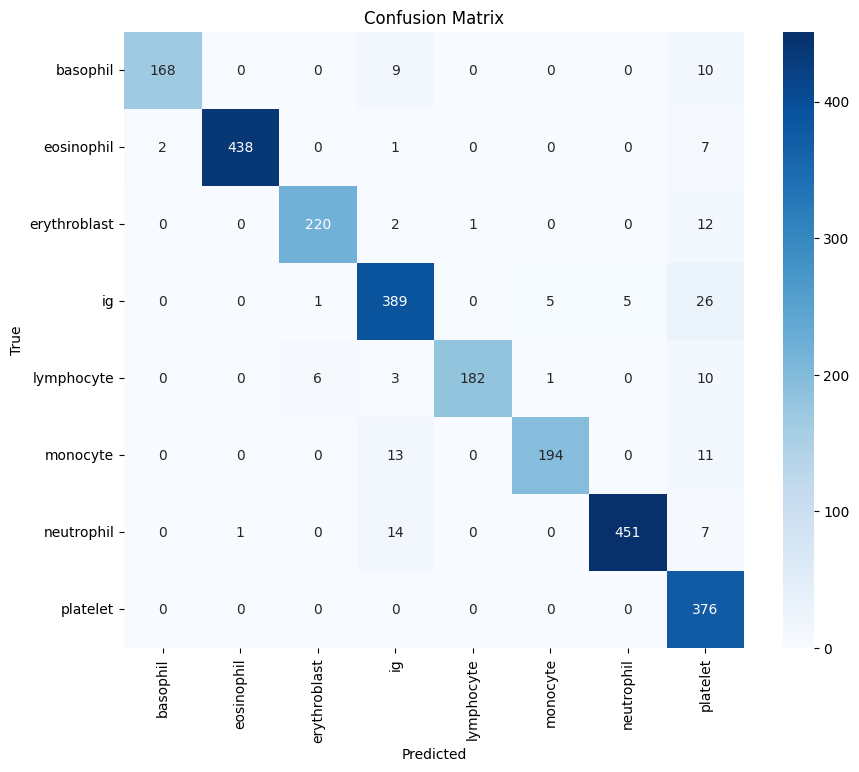

Classification Report:
              precision    recall  f1-score   support

    basophil       0.99      0.90      0.94       187
  eosinophil       1.00      0.98      0.99       448
erythroblast       0.97      0.94      0.95       235
          ig       0.90      0.91      0.91       426
  lymphocyte       0.99      0.90      0.95       202
    monocyte       0.97      0.89      0.93       218
  neutrophil       0.99      0.95      0.97       473
    platelet       0.82      1.00      0.90       376

    accuracy                           0.94      2565
   macro avg       0.95      0.93      0.94      2565
weighted avg       0.95      0.94      0.94      2565



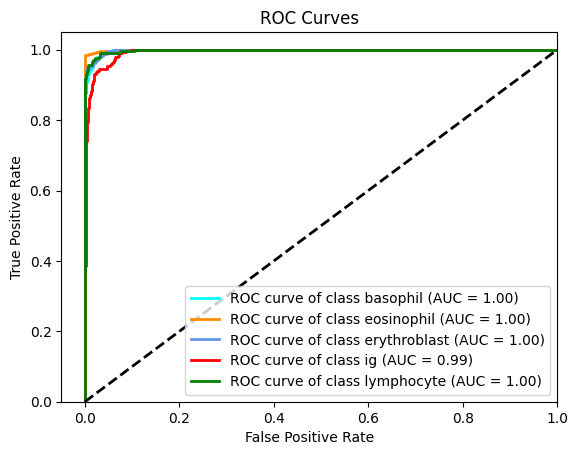

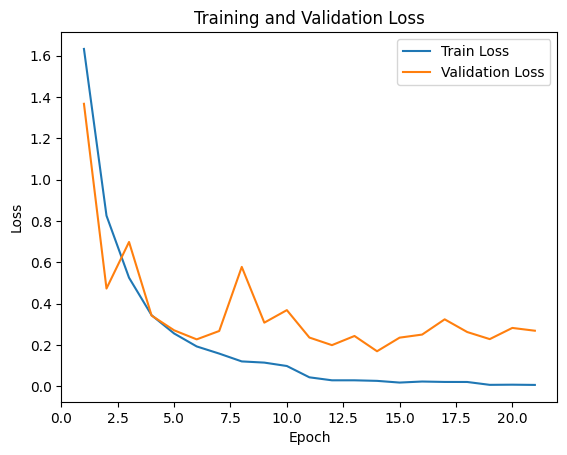

AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute 'next'

In [3]:
# Blood Cell Detection using EfficientNet-b7 in PyTorch with .JPG Images and 8 Classes
# Optimized for GPU Memory Efficiency

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, datasets
import timm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns
import os
from PIL import Image
from torch.cuda import amp  # For mixed-precision training
import gc  # For garbage collection

# -----------------------------
# Configuration and Parameters
# -----------------------------

# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

# Define paths
data_dir = data_dir_path  # Replace with your dataset path

# Hyperparameters
num_classes = 8
batch_size = 2  # Further reduced from 8 to 2 for memory optimization
num_epochs = 50
learning_rate = 1e-4
weight_decay = 1e-5
image_size = 224  # Reduced from 512 to 224 for significant memory savings
patience = 7  # For Early Stopping

# -----------------------------
# Data Preparation
# -----------------------------

# Define data transformations
train_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),
    transforms.RandomApply([transforms.GaussianBlur(3)], p=0.3),
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.3),
    transforms.Normalize([0.485, 0.456, 0.406],  # Mean for ImageNet
                         [0.229, 0.224, 0.225])  # Std for ImageNet
])

val_test_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],  # Mean for ImageNet
                         [0.229, 0.224, 0.225])  # Std for ImageNet
])

# Load the full dataset
full_dataset = datasets.ImageFolder(root=data_dir, transform=train_transforms)

# Calculate dataset sizes for splitting
total_size = len(full_dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(
    full_dataset,
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

# Update transforms for validation and test datasets
val_dataset.dataset.transform = val_test_transforms
test_dataset.dataset.transform = val_test_transforms

# Create DataLoaders
# Adjust num_workers based on your CPU cores; typically, 4 is a good starting point
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

# -----------------------------
# Model Definition
# -----------------------------

# Initialize EfficientNet-b7 model without pretrained weights
# EfficientNet-b7 is a large model; ensure your GPU has sufficient memory
try:
    model = timm.create_model('efficientnet_b7', pretrained=False, num_classes=num_classes)
except RuntimeError as e:
    print(e)
    print("Switching to pretrained=False.")
    model = timm.create_model('efficientnet_b7', pretrained=False, num_classes=num_classes)

model = model.to(device)

# -----------------------------
# Loss Function, Optimizer, Scheduler
# -----------------------------

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

# -----------------------------
# Early Stopping
# -----------------------------

class EarlyStopping:
    def __init__(self, patience=5, verbose=False):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
            verbose (bool): If True, prints a message for each validation loss improvement.
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None or val_loss < self.best_loss:
            if self.verbose and self.best_loss is not None:
                print(f'Validation loss decreased ({self.best_loss:.4f} --> {val_loss:.4f}). Resetting counter.')
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter +=1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True

early_stopping = EarlyStopping(patience=patience, verbose=True)

# -----------------------------
# Training Loop with Mixed-Precision
# -----------------------------

scaler = amp.GradScaler()  # Initialize gradient scaler for mixed-precision

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # Training Phase
    model.train()
    running_train_loss = 0.0
    for inputs, labels in train_loader:
        inputs = inputs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        
        optimizer.zero_grad()
        
        with amp.autocast():
            outputs = model(inputs)
            loss = criterion(outputs, labels)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        running_train_loss += loss.item() * inputs.size(0)
    
    epoch_train_loss = running_train_loss / train_size
    train_losses.append(epoch_train_loss)
    
    # Validation Phase
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            
            with amp.autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)
            
            running_val_loss += loss.item() * inputs.size(0)
    
    epoch_val_loss = running_val_loss / val_size
    val_losses.append(epoch_val_loss)
    
    # Scheduler step
    scheduler.step(epoch_val_loss)
    
    print(f'Epoch [{epoch+1}/{num_epochs}] | Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}')
    
    # Early Stopping
    early_stopping(epoch_val_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered. Stopping training.")
        break
    
    # Clear CUDA cache and perform garbage collection to free memory
    torch.cuda.empty_cache()
    gc.collect()

# -----------------------------
# Evaluation on Test Set
# -----------------------------

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        
        with amp.autocast():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# -----------------------------
# Confusion Matrix
# -----------------------------

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=full_dataset.classes,
            yticklabels=full_dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# -----------------------------
# Classification Report
# -----------------------------

print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=full_dataset.classes))

# -----------------------------
# ROC Curve and AUC
# -----------------------------

from sklearn.preprocessing import label_binarize
from itertools import cycle

# Binarize the labels for ROC computation
y_true = label_binarize(all_labels, classes=range(num_classes))
y_score = np.zeros((len(all_labels), num_classes))

model.eval()
with torch.no_grad():
    for i, (inputs, _) in enumerate(test_loader):
        inputs = inputs.to(device, non_blocking=True)
        with amp.autocast():
            outputs = model(inputs)
            probs = nn.Softmax(dim=1)(outputs).cpu().numpy()
        y_score[i*batch_size:i*batch_size+inputs.size(0)] = probs

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for the first 5 classes
plt.figure()
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green', 'purple', 'brown', 'pink'])
for i, color in zip(range(min(5, num_classes)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {full_dataset.classes[i]} (AUC = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc="lower right")
plt.show()

# -----------------------------
# Plot Training and Validation Loss
# -----------------------------

plt.figure()
plt.plot(range(1, len(train_losses)+1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# -----------------------------
# Display Random Test Images with Predictions
# -----------------------------

def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])  # ImageNet mean
    std  = np.array([0.229, 0.224, 0.225])  # ImageNet std
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title:
        plt.title(title)
    plt.axis('off')  # Hide axis
    plt.pause(0.001)  # Pause for plot to update

# Get a batch of test images
model.eval()
dataiter = iter(test_loader)
images, labels = dataiter.next()
images = images.to(device, non_blocking=True)

with torch.no_grad():
    with amp.autocast():
        outputs = model(images)
    _, preds = torch.max(outputs, 1)

# Plot the images with predictions
plt.figure(figsize=(12, 12))
for idx in range(min(9, images.size(0))):
    ax = plt.subplot(3, 3, idx+1)
    imshow(images.cpu()[idx], title=f'Pred: {full_dataset.classes[preds[idx]]}')
plt.tight_layout()
plt.show()
